# **Analysis of COVID Cases in the Brazilian city of Florianopolis**

### **OBJECTIVE**

#### **The aim of this project is to analyze how the pandemic unfolded in the city of Florianopolis, in Brazil, and try to predict how the number of cases is going to change in the near future. In order to do that, the time series forecast tool called Prophet is going to be used.**

### **1. Importing and filtering the data**

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/rossmodolin/AluraDataScienceBootcamp/main/Module%203/covid19-florianopolis.csv'

data = pd.read_csv(url)
data = data.drop(['city', 'state', 'city_ibge_code', 'place_type'], axis=1)
data.head()

,epidemiological_week,date,order_for_place,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population,is_last,is_repeated
0,202126,2021-06-27,473,76877,15108.70121,0,1008,0,0.0131,508826,False,True
1,202125,2021-06-26,472,76877,15108.70121,0,1008,0,0.0131,508826,False,True
2,202125,2021-06-25,471,76877,15108.70121,84,1008,1,0.0131,508826,True,False
3,202125,2021-06-24,470,76793,15092.19262,82,1007,1,0.0131,508826,False,False
4,202125,2021-06-23,469,76711,15076.07709,38,1006,1,0.0131,508826,False,False


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 12 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   epidemiological_week                           473 non-null    int64  
 1   date                                           473 non-null    object 
 2   order_for_place                                473 non-null    int64  
 3   last_available_confirmed                       473 non-null    int64  
 4   last_available_confirmed_per_100k_inhabitants  473 non-null    float64
 5   new_confirmed                                  473 non-null    int64  
 6   last_available_deaths                          473 non-null    int64  
 7   new_deaths                                     473 non-null    int64  
 8   last_available_death_rate                      473 non-null    float64
 9   estimated_population                           473 non

There seems to be 2 problems with how the data is shown:

- The column 'date' is not in a format that allows us to plot it;
- The data is organized in descending order, from newest to oldest, which may impact visualizations.

This is solved below:

In [ ]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

data = data[::-1]
data.head()

,epidemiological_week,date,order_for_place,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,new_confirmed,last_available_deaths,new_deaths,last_available_death_rate,estimated_population,is_last,is_repeated
472,202011,2020-03-12,1,2,0.39306,2,0,0,0.0,508826,False,False
471,202011,2020-03-13,2,2,0.39306,0,0,0,0.0,508826,False,False
470,202011,2020-03-14,3,2,0.39306,0,0,0,0.0,508826,False,False
469,202012,2020-03-15,4,2,0.39306,0,0,0,0.0,508826,False,False
468,202012,2020-03-16,5,3,0.58959,1,0,0,0.0,508826,False,False


### **2. Preliminary visualizations**

#### **2.1. Latest number of cases reported**

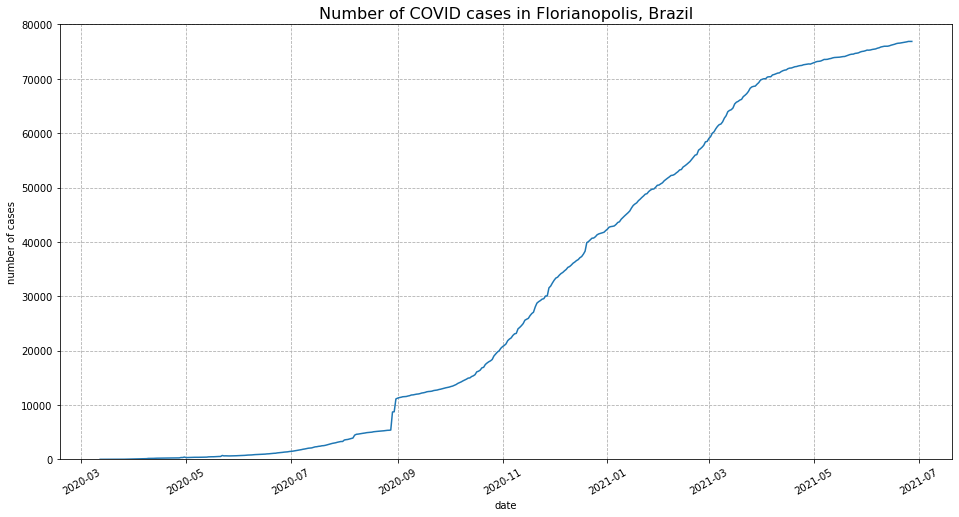

In [ ]:
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.xticks(rotation=30)
plt.ylim((0,80000))

plt.grid(True, linestyle="--")

ax = sns.lineplot(data=data, x='date', y='last_available_confirmed')
ax.set_title('Number of COVID cases in Florianopolis, Brazil', size=16)
ax.set_xlabel("date")
ax.set_ylabel("number of cases")

plt.show()

In order to normalize the data and thus reduce any bias and the effect of outliers, I am going to apply a **log transformation** to it:

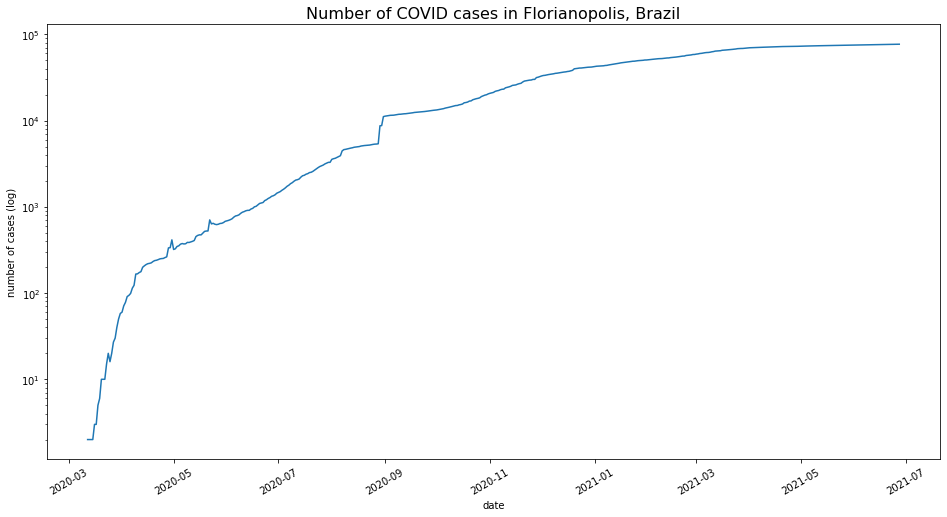

In [ ]:
plt.figure(figsize=(16,8))
plt.xticks(rotation=30)

ax = sns.lineplot(data=data, x='date', y='last_available_confirmed')
ax.set_title('Number of COVID cases in Florianopolis, Brazil', size=16)
ax.set_xlabel("date")
ax.set_ylabel("number of cases (log)")

plt.yscale('log')
plt.show()

#### **2.2. Number of new cases reported**

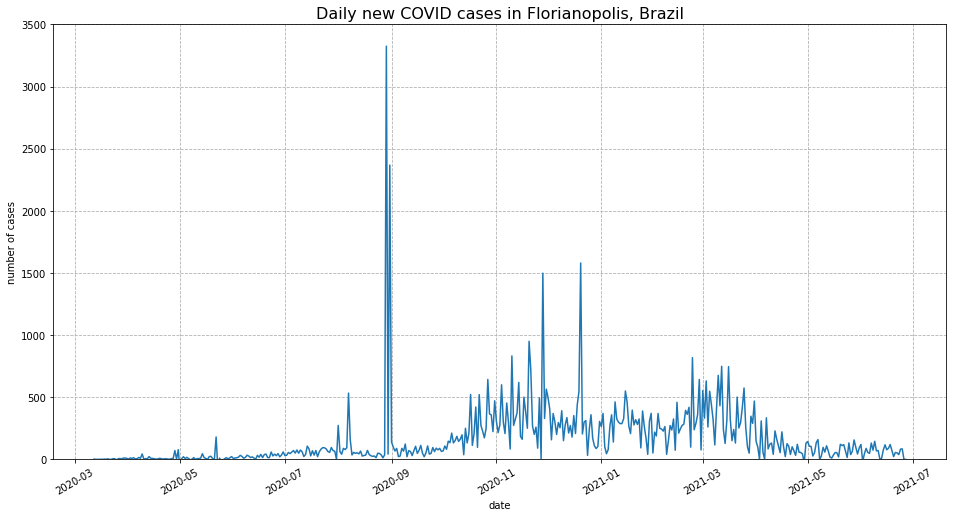

In [ ]:
plt.figure(figsize=(16,8))
plt.xticks(rotation=30)
plt.ylim((0,3500))

plt.grid(True, linestyle="--")

ax = sns.lineplot(data=data, x='date', y='new_confirmed')
ax.set_title('Daily new COVID cases in Florianopolis, Brazil', size=16)
ax.set_xlabel("date")
ax.set_ylabel("number of cases")

plt.show()

#### **2.3. Moving average**

In [ ]:
data['moving_average_cases'] = data['new_confirmed'].rolling(window=7,center=False).mean()

# To prevent warnings from appearing:
import warnings
warnings.filterwarnings('ignore')

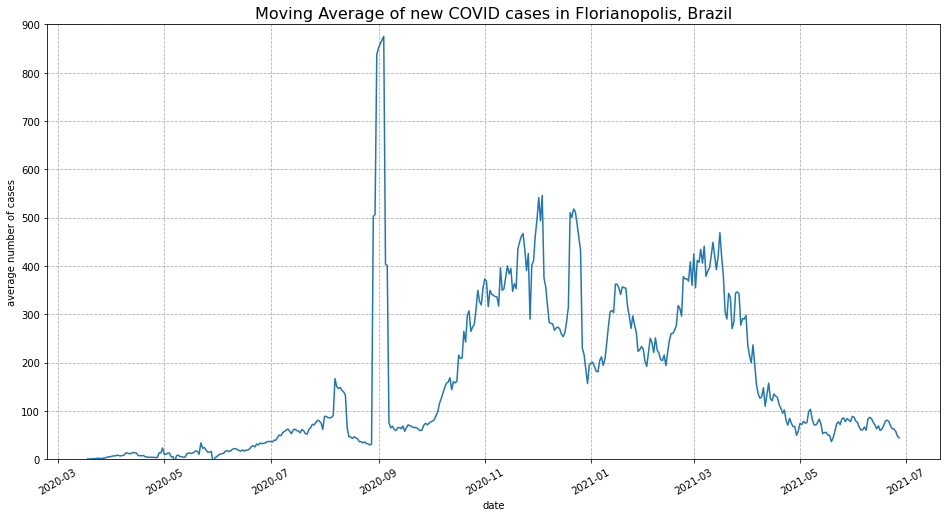

In [ ]:
plt.figure(figsize=(16,8))
plt.xticks(rotation=30)
plt.ylim((0,900))

plt.grid(True, linestyle="--")

ax = sns.lineplot(data=data, x='date', y='moving_average_cases')
ax.set_title('Moving Average of new COVID cases in Florianopolis, Brazil', size=16)
ax.set_xlabel("date")
ax.set_ylabel("average number of cases")

plt.show()

The graphs that have been plotted so far show us that **there does not seem to be any seasonality in the number of cases**. To make sure that this is the case, I am going to plot an interval of 30 days below, to see if any seasonality appears:

#### **2.4. Verifying whether there is seasonality in this time series**

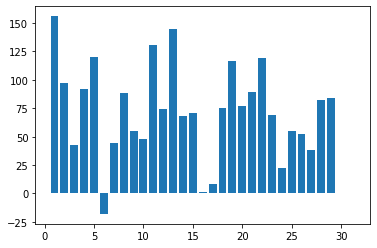

In [ ]:
import numpy as np

data_jun_21 = data[['date', 'new_confirmed', 'moving_average_cases']][-31:] # I chose only one month for this visualization
data_jun_21

plt.bar(np.linspace(1,31,31), data_jun_21['new_confirmed'])
plt.show()

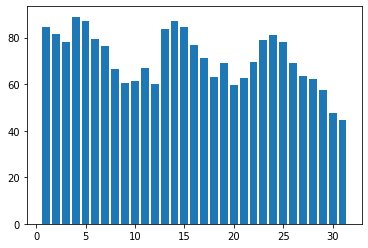

In [ ]:
plt.bar(np.linspace(1,31,31), data_jun_21['moving_average_cases'])
plt.show()

These two visualizations show that, even though there does not seem to be any seasonality when we consider the daily report of new cases, **there seems to be *some* seasonality when the moving average is considered**. In order to further verify this seasonality, an autocorrelation plot can be performed:

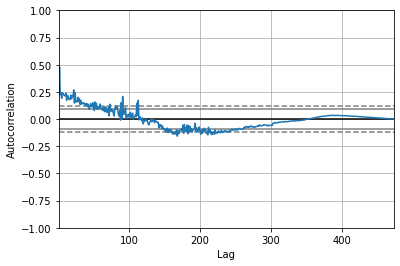

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data['new_confirmed'])
plt.show()

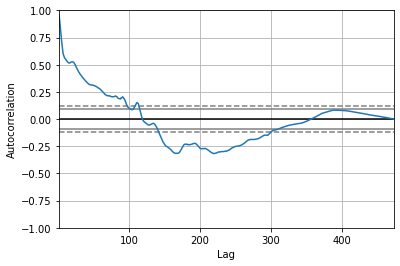

In [ ]:
data['moving_average_cases'] = data['moving_average_cases'].fillna(0)

autocorrelation_plot(data['moving_average_cases'])
plt.show()

By looking at both graphs, we can see that **there is some degree of seasonality only when the moving average is considered**. When plotting the autocorrelation using the daily number of new cases, very few values are above or below the dashed line, which means that very few values are statistically significant.

This further corroborates the seasonality that was observed in the second bar graph above, that shows data related to the moving average.

### **3. Using Prophet to make forecasts**

#### **3.1. Creating the model**

In [ ]:
from fbprophet import Prophet

In [ ]:
df = pd.DataFrame()
df['ds'] = data['date'][:400] # I have selected the first 400 days only
df['y'] = data['moving_average_cases'][:400]
df.head()

,ds,y
472,2020-03-12,0.0
471,2020-03-13,0.0
470,2020-03-14,0.0
469,2020-03-15,0.0
468,2020-03-16,0.0


In [ ]:
model = Prophet(n_changepoints=5, changepoint_range=0.95, changepoint_prior_scale=1)

In [ ]:
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
df_future = model.make_future_dataframe(periods=30)

forecast = model.predict(df_future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-12,3.521093,-143.283586,148.529211,3.521093,3.521093,0.012708,0.012708,0.012708,0.012708,0.012708,0.012708,0.0,0.0,0.0,3.533801
1,2020-03-13,3.525080,-139.469595,151.042953,3.525080,3.525080,-0.138969,-0.138969,-0.138969,-0.138969,-0.138969,-0.138969,0.0,0.0,0.0,3.386111
2,2020-03-14,3.529067,-132.542754,145.069851,3.529067,3.529067,-0.093405,-0.093405,-0.093405,-0.093405,-0.093405,-0.093405,0.0,0.0,0.0,3.435663
3,2020-03-15,3.533055,-135.709811,140.908737,3.533055,3.533055,-0.275910,-0.275910,-0.275910,-0.275910,-0.275910,-0.275910,0.0,0.0,0.0,3.257144
4,2020-03-16,3.537042,-145.412313,139.982701,3.537042,3.537042,0.050322,0.050322,0.050322,0.050322,0.050322,0.050322,0.0,0.0,0.0,3.587365


#### **3.2. Plotting the forecast**

In [ ]:
df_test = pd.DataFrame()
df_test['ds'] = data['date'][400:]
df_test['y'] = data['moving_average_cases'][400:]

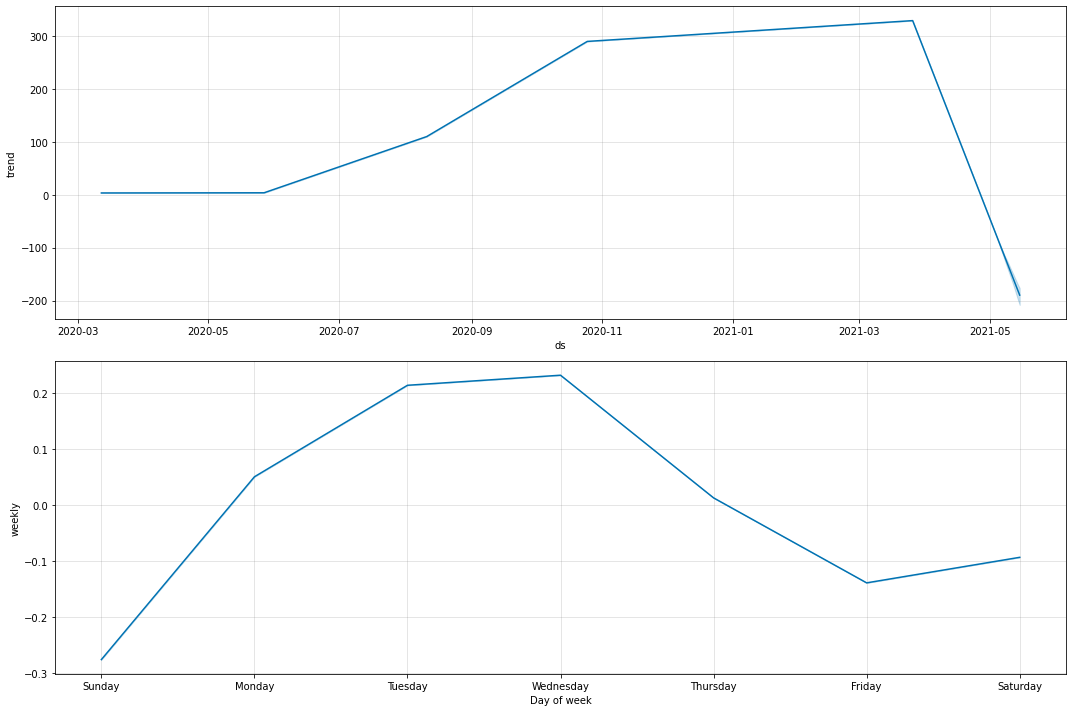

In [ ]:
model.plot_components(forecast, figsize=(15,10));

When plotting the individual components of the forecast, we can see that:
- **(1)** There is a sharp **downward trend** in the number of new cases, which probably coincides with the beginning of vaccinations in Brazil;
- **(2)** There is a **weekly seasonality** in the data, with the number of cases peaking on Wednesday and falling towards the weekend. This may be related to when the government database is updated every week.

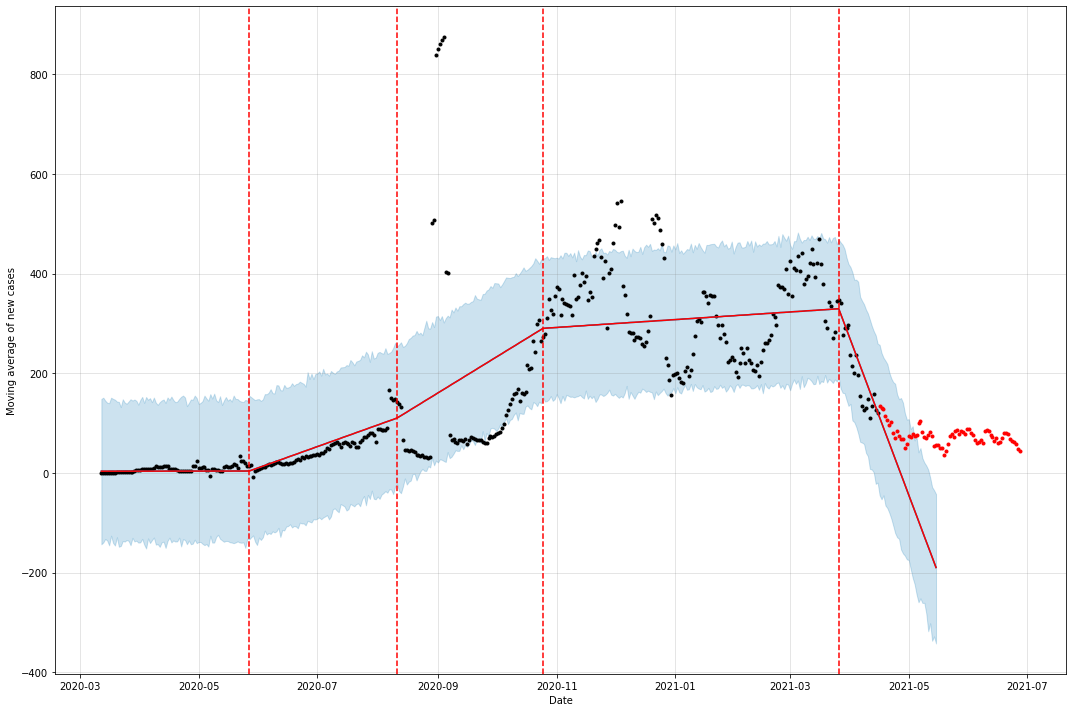

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast, xlabel='Date', ylabel='Moving average of new cases', figsize=(15,10));
a = add_changepoints_to_plot(fig.gca(), model, forecast)

plt.plot(df_test['ds'], df_test['y'], '.r')
plt.show()

### **4. Conclusion**

This prediction allows us to say that **the downward trend in the number of cases is likely to continue**, although the further away the prediction is from the actual data, the less accurate it becomes. We can see this likely decrease in accuracy by looking at the red dots (the forecast), as only some of them fall within the confidence interval (the light blue around the main line).